In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency


In [2]:
df = pd.read_csv('resources/train.csv')
df.head()

,TransactionID,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,C6,C7,C8,C9,C10,C11,C12,C13,C14,isFraud
0,1,C,5812,408.0,185.0,mastercard,224.0,debit,NotFound,NotFound,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0
1,2,W,12577,268.0,150.0,visa,166.0,debit,123.0,87.0,...,94.0,0.0,0.0,85.0,0.0,104.0,0.0,457.0,120.0,0
2,3,H,12581,453.0,150.0,visa,226.0,debit,272.0,87.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0
3,4,W,8139,327.0,150.0,discover,194.0,credit,204.0,87.0,...,2.0,0.0,0.0,2.0,0.0,3.0,0.0,18.0,6.0,0
4,5,W,16132,111.0,150.0,visa,226.0,debit,220.0,87.0,...,2.0,0.0,0.0,1.0,0.0,1.0,0.0,28.0,1.0,0


In [3]:
df.isna().sum()
#No missing values
#missing values are represented by not found values in the dataset

TransactionID     0
ProductCD         0
card1             0
card2             0
card3             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
TransactionDT     0
TransactionAmt    0
C1                0
C2                0
C3                0
C4                0
C5                0
C6                0
C7                0
C8                0
C9                0
C10               0
C11               0
C12               0
C13               0
C14               0
isFraud           0
dtype: int64

In [4]:
from sklearn.preprocessing import OneHotEncoder

In [5]:
df.replace('NotFound', pd.NA, inplace=True)

# Iterate over columns to handle 'NotFound' appropriately
for column in df.columns:
    # If the column is numerical but contains NA (previously 'NotFound')
    if df[column].dtype in ['float64', 'int64'] and df[column].isna().any():
        df[column].fillna(0, inplace=True)  # Replace NA with 0 for numerical columns
    elif df[column].dtype == 'object' and df[column].isna().any():
        mode = df[column].mode()[0] if df[column].mode().size > 0 else 'Unknown'
        df[column].fillna(mode, inplace=True)  # Replace NA with mode for categorical columns

# Ensure all data is in the correct format before encoding
df = df.convert_dtypes()

In [6]:
def find_mixed_type_columns(df):
    mixed_type_columns = []
    for column in df.columns:
        # Get unique data types of all non-NA entries in the column
        unique_types = {type(v) for v in df[column].dropna()}
        # Check if there are both string and numeric types within the unique types
        if (str in unique_types or type('') in unique_types) and (int in unique_types or float in unique_types):
            mixed_type_columns.append(column)
    return mixed_type_columns

print(find_mixed_type_columns(df))

[]


In [7]:
print(df['addr1'].unique())
print(df['addr2'].unique())

<StringArray>
['299.0', '123.0', '272.0', '204.0', '220.0', '205.0', '441.0', '315.0',
 '337.0', '343.0',
 ...
 '235.0', '249.0', '457.0', '530.0', '368.0', '164.0', '338.0', '298.0',
 '245.0', '481.0']
Length: 303, dtype: string
<StringArray>
[ '87.0',  '96.0',  '60.0',  '29.0',  '31.0', '102.0',  '16.0',  '65.0',
  '30.0',  '43.0',  '26.0',  '20.0',  '92.0',  '61.0',  '18.0',  '69.0',
  '54.0',  '59.0',  '24.0',  '10.0',  '57.0',  '19.0',  '21.0',  '39.0',
  '88.0',  '32.0',  '27.0',  '98.0',  '34.0',  '77.0',  '68.0',  '49.0',
  '23.0',  '71.0',  '76.0',  '51.0',  '46.0',  '78.0',  '52.0',  '28.0',
  '93.0',  '13.0',  '74.0',  '36.0', '101.0',  '62.0',  '63.0',  '44.0',
  '48.0',  '17.0',  '84.0',  '79.0',  '40.0',  '35.0',  '72.0',  '70.0',
  '38.0',  '50.0',  '47.0',  '22.0', '100.0',  '73.0',  '55.0',  '97.0',
  '66.0',  '14.0',  '94.0',  '82.0',  '86.0',  '15.0',  '89.0']
Length: 71, dtype: string


In [8]:
#making sure that addr1 and addr2 are numerical since there was qoutation marks was coming out as 
df['addr1'] = pd.to_numeric(df['addr1'], errors='coerce')
df['addr2'] = pd.to_numeric(df['addr2'], errors='coerce')
df['addr1'].head()

0    299.0
1    123.0
2    272.0
3    204.0
4    220.0
Name: addr1, dtype: float64

In [9]:
categorical_df = df.select_dtypes(include=['object', 'category','string'])
print(categorical_df)


       ProductCD  card2  card3       card4  card5   card6
0              C  408.0  185.0  mastercard  224.0   debit
1              W  268.0  150.0        visa  166.0   debit
2              H  453.0  150.0        visa  226.0   debit
3              W  327.0  150.0    discover  194.0  credit
4              W  111.0  150.0        visa  226.0   debit
...          ...    ...    ...         ...    ...     ...
472427         W  562.0  150.0  mastercard  102.0  credit
472428         W  481.0  150.0  mastercard  224.0   debit
472429         W  205.0  150.0        visa  166.0   debit
472430         W  476.0  150.0        visa  166.0   debit
472431         H  583.0  150.0        visa  226.0  credit

[472432 rows x 6 columns]


In [10]:
df['card2']= pd.to_numeric(df['card2'],errors='coerce')
df['card3'] = pd.to_numeric(df['card3'],errors='coerce')
df['card5'] = pd.to_numeric(df['card5'],errors='coerce')

In [11]:
categorical_df = df.select_dtypes(include=['object', 'category','string'])
print(categorical_df)

       ProductCD       card4   card6
0              C  mastercard   debit
1              W        visa   debit
2              H        visa   debit
3              W    discover  credit
4              W        visa   debit
...          ...         ...     ...
472427         W  mastercard  credit
472428         W  mastercard   debit
472429         W        visa   debit
472430         W        visa   debit
472431         H        visa  credit

[472432 rows x 3 columns]


In [12]:
# Now, one-hot encode the categorical columns
encoder = OneHotEncoder(sparse=False)
categorical_columns = df.select_dtypes(include=['object', 'string','boolean']).columns
encoded_data = encoder.fit_transform(df[categorical_columns])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names(categorical_columns))

df_encoded = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

/Users/migcord/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


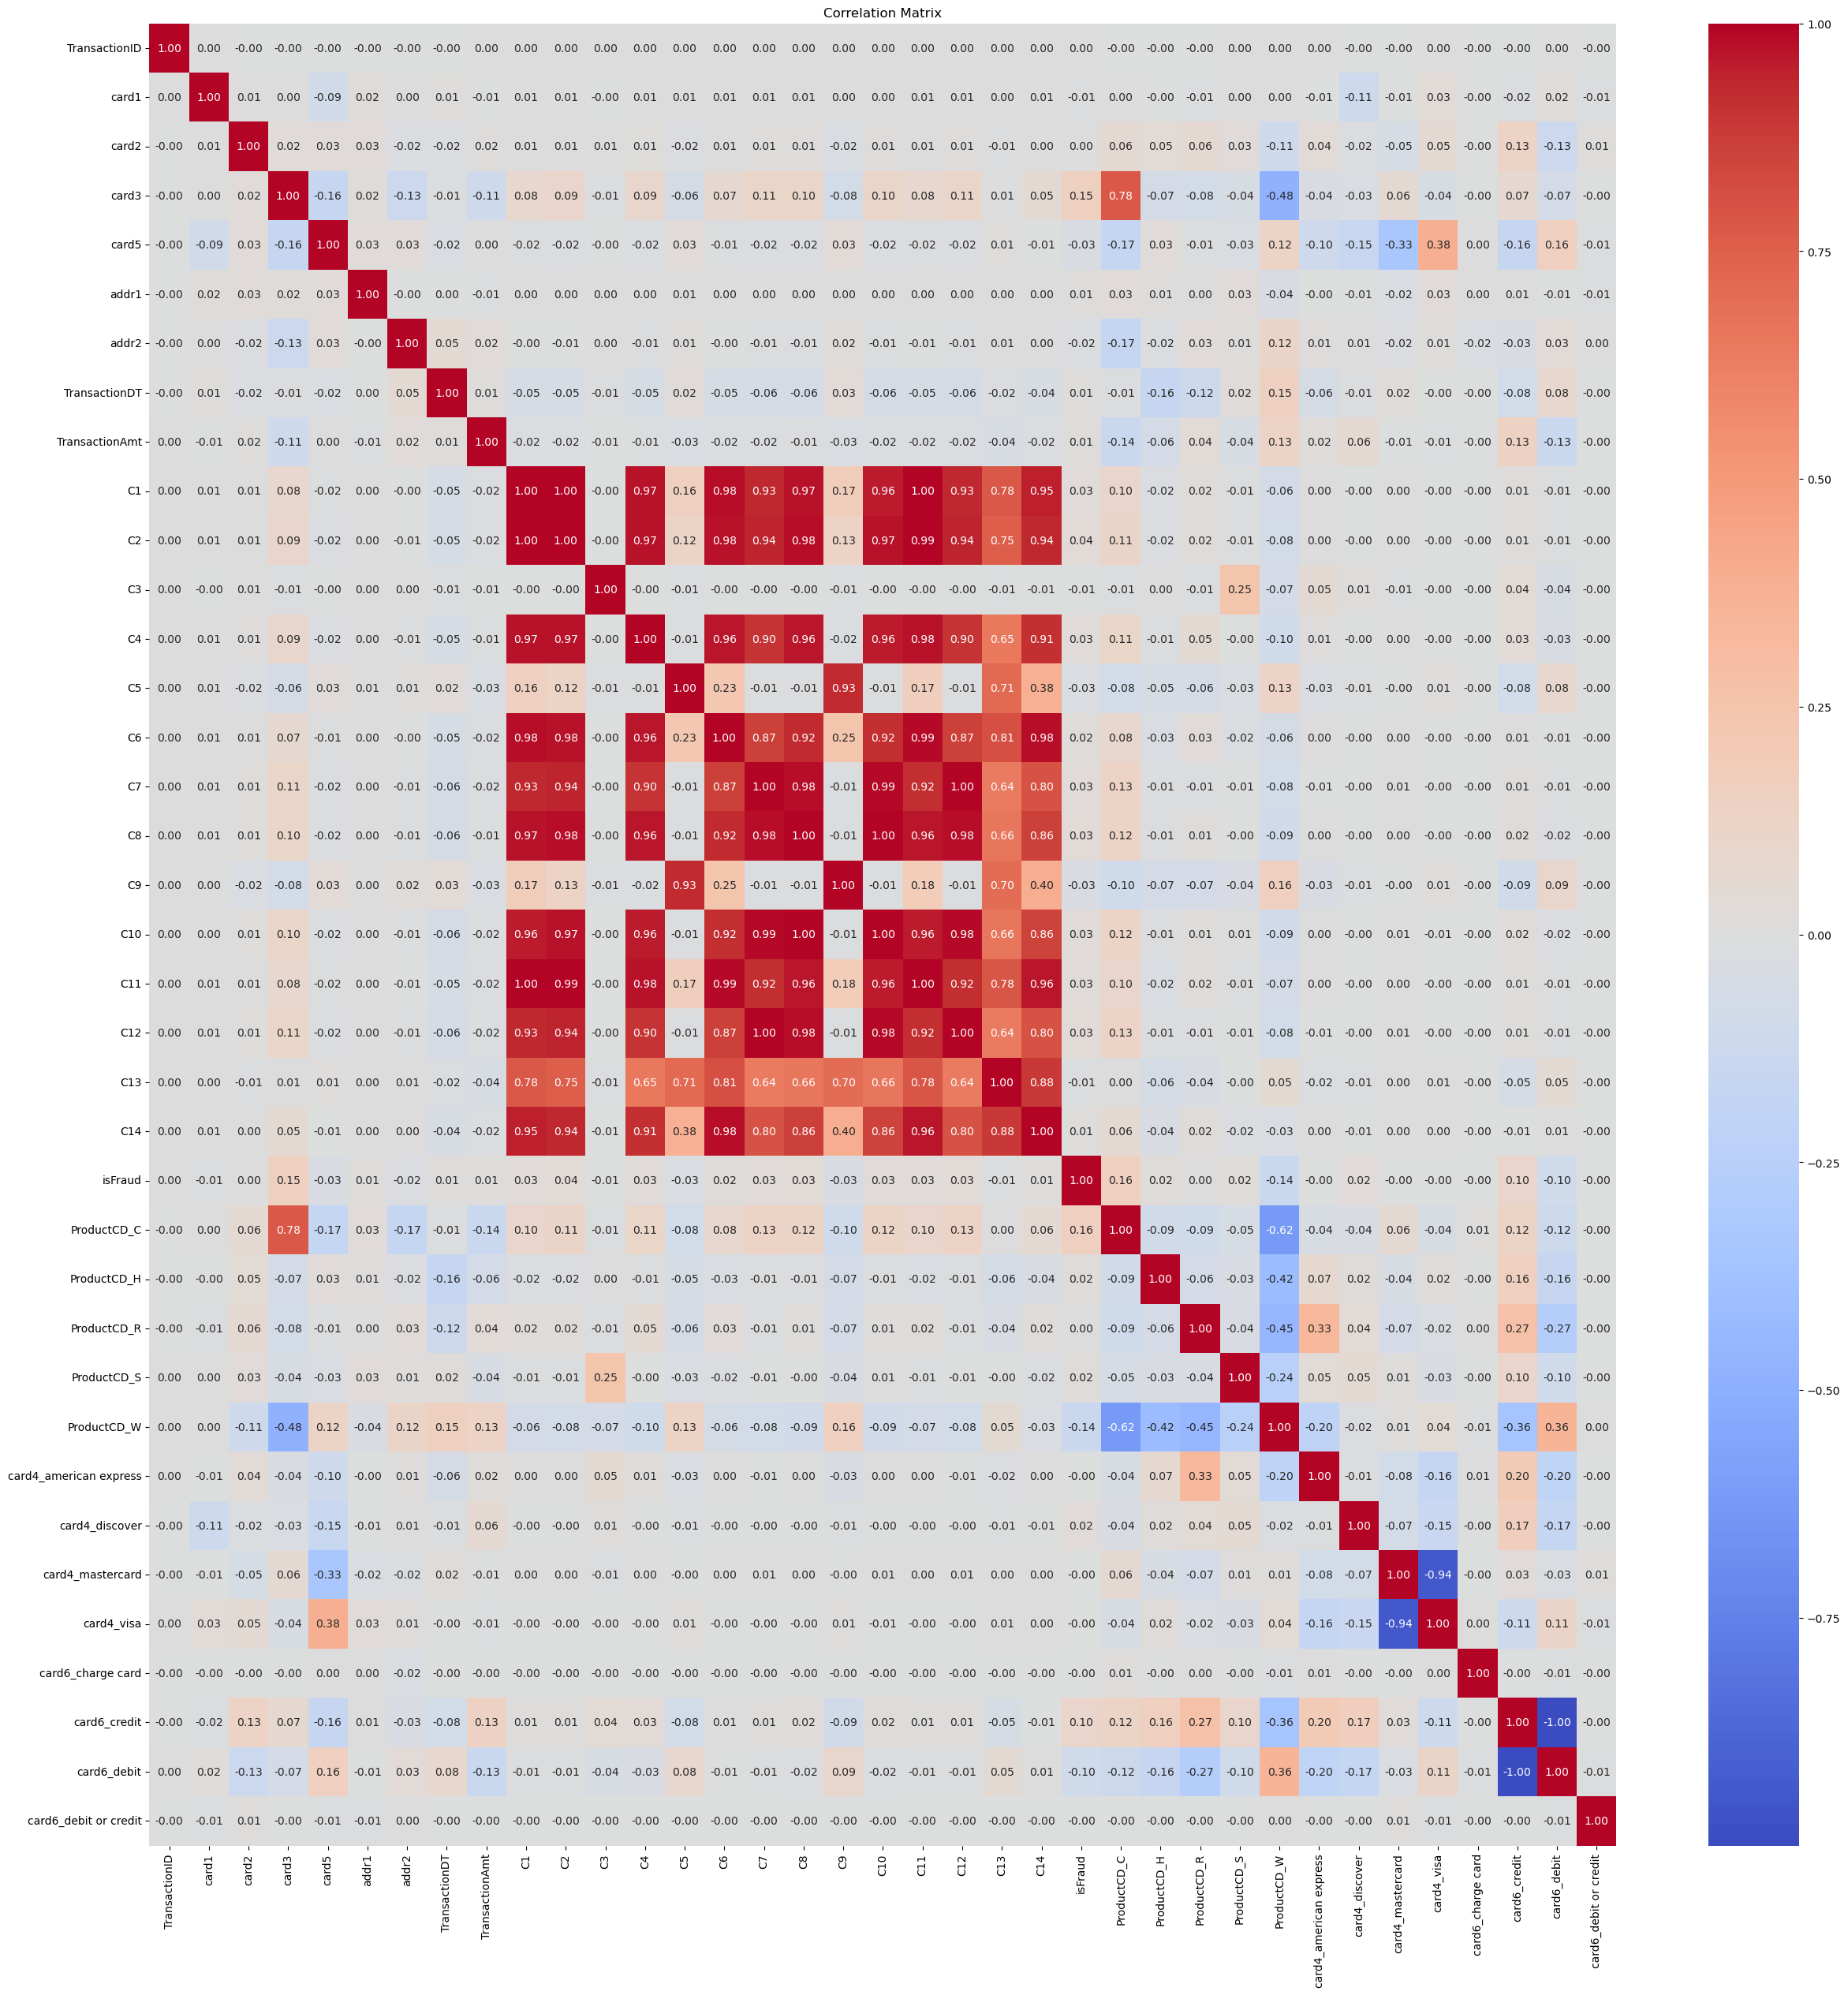

In [13]:
corr_matrix = df_encoded.corr()

plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [20]:
#Only want features that are highly correlated with the target
target_corr = corr_matrix['isFraud'].drop('isFraud')  # Exclude self-correlation
# very low target threshold
threshold = 0.05
# Identify features that have a high correlation with the target
highly_correlated_features = target_corr[abs(target_corr) > threshold].index.tolist()
highly_correlated_features, target_corr[highly_correlated_features]

(['card3', 'ProductCD_C', 'ProductCD_W', 'card6_credit', 'card6_debit'],
 card3           0.154848
 ProductCD_C     0.162013
 ProductCD_W    -0.135446
 card6_credit    0.101294
 card6_debit    -0.101253
 Name: isFraud, dtype: float64)

In [25]:
#Now we will perform a chi squared test to see what features of categorcial work
target = 'isFraud' 

categorical_cols = df.select_dtypes(include=['object', 'category','string']).columns.tolist()

results = []

for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df[target])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    results.append({
        'Feature': col,
        'Chi2': chi2,
        'p-value': p,
        'Degrees of freedom': dof
    })

results_df = pd.DataFrame(results)
print(results_df)

     Feature          Chi2       p-value  Degrees of freedom
0  ProductCD  13441.026286  0.000000e+00                   4
1      card4    298.505352  2.095319e-64                   3
2      card6   4847.948642  0.000000e+00                   3


In [26]:
# from these results we can see that we can keep these colmns
# 'ProductCD', 'card4', 'card6', 'card3'

In [28]:
columns_to_keep = ['ProductCD', 'card4', 'card6', 'card3', 'isFraud']
df_final = df[columns_to_keep]
df_final.head()

,ProductCD,card4,card6,card3,isFraud
0,C,mastercard,debit,185.0,0
1,W,visa,debit,150.0,0
2,H,visa,debit,150.0,0
3,W,discover,credit,150.0,0
4,W,visa,debit,150.0,0


In [32]:
train = df_final
train.to_csv('resources/clened_train.csv', index=False)
test = pd.read_csv('resources/test.csv')
columns_to_keep = ['ProductCD', 'card4', 'card6', 'card3']
test = test[columns_to_keep]
test.replace('NotFound', pd.NA, inplace=True)

for column in test.columns:
    # If the column is numerical but contains NA
    if test[column].dtype in ['float64', 'int64'] and test[column].isna().any():
        test[column].fillna(0, inplace=True)  # Replace NA with 0 for numerical columns
    elif test[column].dtype == 'object' and test[column].isna().any():
        mode = test[column].mode()[0] if test[column].mode().size > 0 else 'Unknown'
        test[column].fillna(mode, inplace=True)  # Replace NA with mode for categorical columns

test = test.convert_dtypes()
test['card3'] = pd.to_numeric(test['card3'], errors='coerce')

test.to_csv('resources/cleaned_test.csv', index=False)